<a href="https://www.kaggle.com/code/seastoexist/feedfoward-nn?scriptVersionId=193264066" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from datasets import load_dataset, Dataset
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
import numpy as np
import gc

nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load datasets
imdb = load_dataset('stanfordnlp/imdb')
sst2 = load_dataset('glue', 'sst2')


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [3]:
# Prepare dataset splits
imdbTr = imdb['train']
imdbTe = imdb['test']
sst2Tr = sst2['train']
sst2Te = sst2['validation']

# Convert datasets to lists
imdbTrL = [example for example in imdbTr]
imdbTeL = [example for example in imdbTe]
sst2TrL = [example for example in sst2Tr]
sst2TeL = [example for example in sst2Te]

#Append datasets
trainList = imdbTrL + sst2TrL
testList = imdbTeL + sst2TeL

train = Dataset.from_list(trainList)
test = Dataset.from_list(testList)

In [4]:
# Add is_long feature to differentiate between sst2 and imdb samples
sth = 100
def add_is_long(example, threshold=sth):
    text = example.get('text', example.get('sentence', ''))
    tokens = word_tokenize(str(text))
    example['is_long'] = int(len(tokens) > threshold)
    return example

train = train.map(add_is_long)
test = test.map(add_is_long)

Map:   0%|          | 0/92349 [00:00<?, ? examples/s]

Map:   0%|          | 0/25872 [00:00<?, ? examples/s]

In [5]:
# Define neural network
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1) #2 hidden layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

Average Accuracy: 89.29%, Average Loss: 0.7124


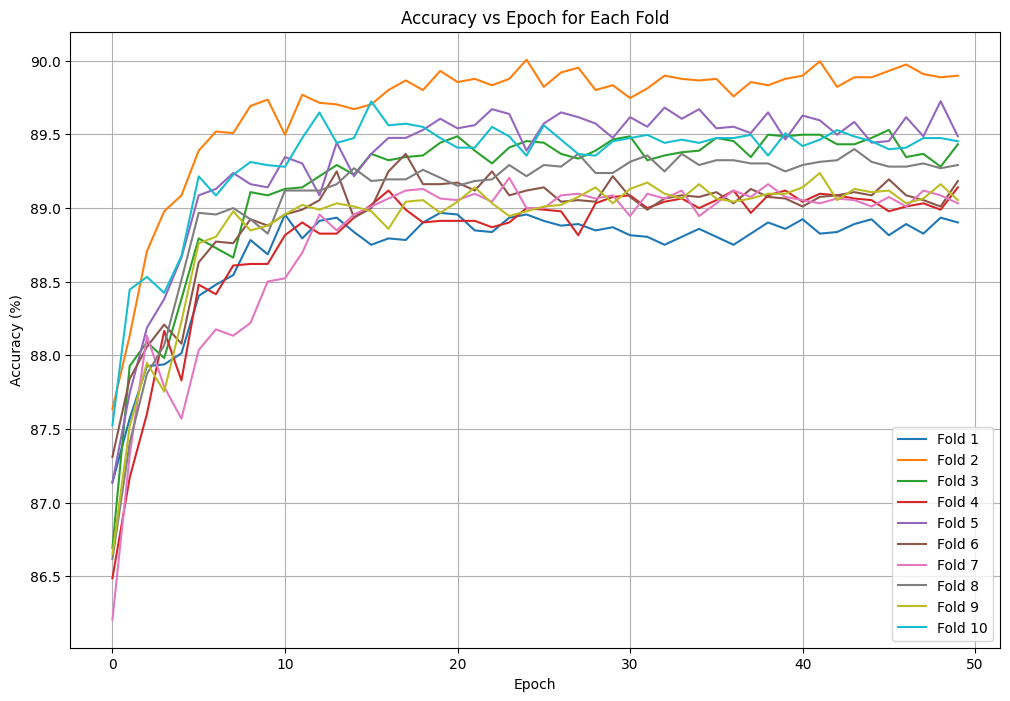

In [6]:
def run_kfold(k, trainList):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_losses = []
    epoch_accuracies = []

    for fold, (train_index, val_index) in enumerate(kf.split(trainList)):
        train_data = [trainList[i] for i in train_index]
        val_data = [trainList[i] for i in val_index]
        
        # Tfidf encoding
        vectorizer = TfidfVectorizer(max_features=10000)
        train_texts = [' '.join(word_tokenize(str(example.get('text', example.get('sentence', ''))))) for example in train_data]
        val_texts = [' '.join(word_tokenize(str(example.get('text', example.get('sentence', ''))))) for example in val_data]
        X_train_fold = vectorizer.fit_transform(train_texts).toarray()
        X_val_fold = vectorizer.transform(val_texts).toarray()

        # Add is_long feature
        train_is_long = np.array([example.get('is_long', 0) for example in train_data]).reshape(-1, 1)
        val_is_long = np.array([example.get('is_long', 0) for example in val_data]).reshape(-1, 1)
        X_train_fold = np.hstack((X_train_fold, train_is_long))
        X_val_fold = np.hstack((X_val_fold, val_is_long))

        # Scikit-learn StandardScaler to center data
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        # Create tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor([example['label'] for example in train_data], dtype=torch.float32).unsqueeze(1)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor([example['label'] for example in val_data], dtype=torch.float32).unsqueeze(1)
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

        input_dim = X_train_fold.shape[1]
        model = FeedforwardNN(input_dim)
        
        # BCE loss function
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        num_epochs = 50

        # Accuracy calculation and epochs
        accuracies_per_fold = []
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
                val_outputs = (val_outputs > 0.5).float()
                accuracy = (val_outputs.eq(y_val_tensor).sum().item() / len(y_val_tensor)) * 100
                accuracies_per_fold.append(accuracy)

            scheduler.step()

        fold_accuracies.append(accuracy)
        fold_losses.append(val_loss)
        epoch_accuracies.append(accuracies_per_fold)

        # Clear up space
        del model, optimizer, X_train_fold, X_val_fold, y_train_tensor, y_val_tensor
        del train_dataset, train_loader, X_train_tensor, X_val_tensor
        gc.collect()

    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)
    print(f'Average Accuracy: {avg_accuracy:.2f}%, Average Loss: {avg_loss:.4f}')

    # Plot accuracy vs epoch
    plt.figure(figsize=(12, 8))
    for fold, accuracies in enumerate(epoch_accuracies):
        plt.plot(accuracies, label=f'Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epoch for Each Fold')
    plt.legend()
    plt.grid(True)
    plt.show()
k = 10
run_kfold(k, trainList)